# Wind field scoring functions
Begin by importing needed functions.

In [2]:
# We want to work with modules from parent directory
import sys
sys.path.append('../')
# Some of the data loading functions produce warnings,
# Let's supress them for neatness sake.
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML

# Decrease the size of the scroll window, the information is not relevant.
display(HTML("<style>div.output_scroll { height: 5em; }</style>"))

from error_estimation.windfield_prediction import do_random_predictions, get_mean_square_error, prediction_errors, get_square_error
from error_estimation.error_analysis_plots import plot_ridgeline, get_error_table
from models.averaging_windfield import AveragingWindfield
from models.nn_windfield import NearestNeighbourWindfield
import framework.data_loader as dl
from framework.plotter import setup_plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load sweden map (for plotting)
swe_map = dl.load_shape_file_from_url(url="https://www.enblom.org/sweden-map.zip")

## `windfield_prediction.py`
The file `windfield_prediction.py` contains useful functions for analysing the accuracy of a windfield model. 
The function `do_many_predictions()` uses k-fold validation to generate velocity predictions for a subset of times of data frame containing measurements. The mandatory inputs are

* `wind_field` , the wind field model.
* `wind_data`, a `WindDataFrame` with wind measurements.
* `times`, a `numpy.array` with datetime objects signifying the times to predict.

There are a couple of optional arguments as well,

* `n_splits`, the number of folds to use in the k-fold validation.
* `seed`, the seed to use for the k-fold validation.

An alternative to `do_many_predictions()` is `do_random_predictions()`, where the `times` variable is replaced by a random sample of the available times in the data. The number of samples is specified by the argument `n_samples`. The functions return a `WindDataFrame` with two extra columns, `u_pred` and `v_pred` containing the generated velocity predictions. Here's an example how the function can be used:

In [11]:
# Load some data
data = dl.load_parquet("../Data/wind_data_2018.parquet")

# Create windfield
wf = AveragingWindfield()   # <- this can be any windfield. 

# Make predictions using 5-fold validation
predictions = do_random_predictions(wf, data, n_samples = 100, n_splits = 5, seed = 100)

# Print predictions
predictions

,x,y,u,v,station_id,altitude,height,date,time,datetime,u_pred,v_pred,Fold_index
0,373015.160293,6.163951e+06,2.768827,0.862322,52350,3,10,2018-01-30,21:00,2018-01-30 21:00:00,4.832225,2.420623,1.0
1,366589.419721,6.241324e+06,4.408381,2.359275,62180,18,10,2018-01-30,21:00,2018-01-30 21:00:00,4.488061,2.749403,1.0
2,382004.426352,6.313428e+06,2.904915,1.565716,63590,133,10,2018-01-30,21:00,2018-01-30 21:00:00,2.309523,1.162955,1.0
3,516985.401289,6.235263e+06,2.815663,1.035394,65160,58,10,2018-01-30,21:00,2018-01-30 21:00:00,4.488280,1.354449,1.0
4,313478.944244,6.355302e+06,6.283124,4.621943,71190,4,10,2018-01-30,21:00,2018-01-30 21:00:00,3.291105,2.827164,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16516,842908.222100,7.263316e+06,1.637293,2.146921,162790,2,10,2018-03-17,04:00,2018-03-17 04:00:00,0.747144,-0.200600,5.0
16517,870976.641886,7.310100e+06,4.042644,-0.683394,163900,2,10,2018-03-17,04:00,2018-03-17 04:00:00,0.838494,-0.274714,5.0
16518,915209.249174,7.330462e+06,1.247652,0.365191,163960,13,10,2018-03-17,04:00,2018-03-17 04:00:00,0.926870,-0.419652,5.0
16519,701320.876594,7.558889e+06,0.267773,-2.787167,189720,494,10,2018-03-17,04:00,2018-03-17 04:00:00,1.593181,-0.434345,5.0


 We can then use the function `get_mean_square_error()` to evaluate the accuracy of the predictions:

In [12]:
# Print 1-R^2 (fraction of unexplained variance) of the above predictions:
print("1-R^2: ", get_mean_square_error(predictions, normalize=True))

# Prine MSE error of the above predictions:
print("MSE: ", get_mean_square_error(predictions, normalize=False))

1-R^2:  0.3904064700958294
MSE:  7.305225798628245


The `get_mean_square_error()` function with `normalize` set to false simply computes the mean square error of the predictions. If it is set to true, the function computes the fraction of unexplained variance ($1-R^2$) in the velocity. Meaning, if $\{u_i,v_i\}_{i=1}^N$ are the measured velocities and $\{u^p_i, v^p_i\}_{i=1}^N$ are the predictions, the function returns

$$
    \frac{\frac{1}{N}\sum_{i=1}^N (u_i-u^p_i)^2+(v_i-v^p_i)^2}{\frac{1}{N}\sum_{i=1}^N u_i^2+v_i^2},
$$

As opposed to normalizing the errors pointwise. Note that the expression in the denominator is exactly the mean square error. The two functions `do_random_predictions()` and `get_mean_square_error()` are extremely useful for analysing the error of a windfield model. We can for example group the predictions by station and apply `get_mean_square_error()` to each group respectively. 

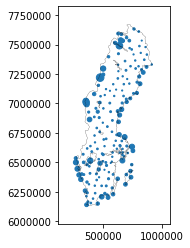

In [25]:
# Get station positions
stations = data[["station_id", "x", "y"]].drop_duplicates()
# Get errors by station
stations["error"] = predictions.groupby("station_id").apply(get_mean_square_error).values

# Plot errors 
fig, ax, _, _, _, _, _, _ = setup_plot(swe_map)
swe_map.plot(ax=ax, edgecolor="black", linewidth=.2)

# Scatter plot of the station locations, each point scaled according to prediction error.
plt.scatter("x", "y", s="error", data=stations)

The `do_many_predictions` function works fine as a single process when the number of samples is relatively small, but when doing hyper optimisation for example, it is useful to divide the task of training and predicting into several sub tasks so that multiprocessing can be used to reduce computation time. For this task, consider `do_parallel_5fold()`. It takes the arguments

* `windfields`, A python list of `WindField` objects.
* `data_folder`, A folder of data frames generated by the function `split_and_save_data()`.
* `save_folder`, A folder where the predictions are saved.
* `n_samples`, Number of random samples to pick from the data folder
* `seed`, Random seed for picking the samples.
* `processes`, Number of parallel processes to use for generating predictions.
* `random`, A boolean. If True, the data samples will be chosen randomly. If False, the first `n_samples` data frames will be chosen from the data folder.

A general pipeline for doing a hyper-parameter analysis is as follows:

* Generate data using `split_and_save_data()`
* Define a set of windfields with different hyper parameters
* Generate predictions using `do_many_predictions()`
* Retrieve the predictions from `save_folder`. 
* Use `get_mean_square_error()` to evaluate the performance.

This pipeline is employed in the `multiproc_fourier_features_optimisation.py` and `multiproc_predictions.py` perform hyper optimisation as well model comparisons.

## `error_analysis_plots.py`
The code in `error_analysis_plots.py` provide some rudimentary tools for analysing the accuracy of the above error estimates. The function `plot_ridgeline()` plots a set of histograms showing the distribution of the mean square errors. The function has only one input, `windfield_errors`. This input is a DataFrame with errors along the columns, which can be obtained using the same `groupby` + `get_mean_square_error()` technique employed above, but with respect to time. To make it interesting, let's first generate predictions with another windfield.

In [21]:
nn_wf = NearestNeighbourWindfield()

# Make predictions using 5-fold validation
predictions_nn = do_random_predictions(nn_wf, data, n_samples = 100, n_splits = 5, seed = 100)

Next, plot the results using the `plot_ridgeline()` function. The function is tuned for relative errors with a range between 0 and 1.2, so the errors need to be normalised by the mean square wind speed.

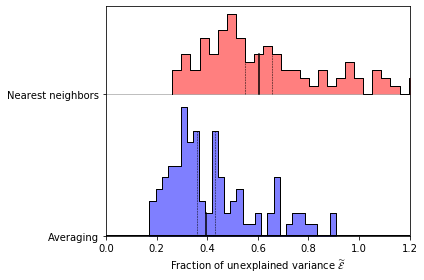

In [22]:
# Create error frame
errors = pd.DataFrame()
errors["Averaging"] = predictions.groupby("datetime").apply(get_mean_square_error)# Errors of first model
errors["Nearest neighbors"] = predictions_nn.groupby("datetime").apply(get_mean_square_error) # Errors of second model

# Normalise with mean square wind speed
msq_wind = (data.v**2 + data.u**2).mean()
errors /= msq_wind

# Plot results as a ridgeline plot
plot_ridgeline(errors)

The thick black lines mark the mean of the distribution, and the dashed black lines mark confidence intervals for tis mean.
The exact confidence intervals can be obtained using the `get_error_table()` function. Into the function we input the errors as well as the mean square wind speed. The function returns a table with columns:
* name: The name of the model (Taken from the `errors` DataFrame input)
* MSE: mean square error (the mean along each column in `errors`)
* MSEci: Confidence interval for MSE (two standard deviations of each column `errors` divided by the root of the number of samples)
* nMSE: Normalised mean square error
* nMSEci: Confidence interval for nMSE

The argument `print_tex_string` is a boolean which produces a LaTex style printout of the table in the command line.

In [24]:
table = get_error_table(errors, msq_wind, print_tex_string=True)
table

Nearest neighbors & 0.603 $\pm$ 0.053 & 11.163 $\pm$ 0.980 \\
Averaging & 0.395 $\pm$ 0.035 & 7.307 $\pm$ 0.644 \\


,MSE,MSEci,nMSE,nMSEci,name
1,11.163160,0.979617,0.602965,0.052913,Nearest neighbors
0,7.307091,0.643590,0.394684,0.034763,Averaging
